### Лучший скор : 0.8075426522982592

In [152]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import (LogisticRegression , LogisticRegressionCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

### Загрузим данные

In [3]:
PATH_TO_DATA = "data"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

### Посмотрим, как выглядят наши данные

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


Какие именно признаки у нас есть в наших данных

In [112]:
for i in range(len(df_train_features.columns)):
    print(df_train_features.columns[i])

game_time
game_mode
lobby_type
objectives_len
chat_len
r1_hero_id
r1_kills
r1_deaths
r1_assists
r1_denies
r1_gold
r1_lh
r1_xp
r1_health
r1_max_health
r1_max_mana
r1_level
r1_x
r1_y
r1_stuns
r1_creeps_stacked
r1_camps_stacked
r1_rune_pickups
r1_firstblood_claimed
r1_teamfight_participation
r1_towers_killed
r1_roshans_killed
r1_obs_placed
r1_sen_placed
r2_hero_id
r2_kills
r2_deaths
r2_assists
r2_denies
r2_gold
r2_lh
r2_xp
r2_health
r2_max_health
r2_max_mana
r2_level
r2_x
r2_y
r2_stuns
r2_creeps_stacked
r2_camps_stacked
r2_rune_pickups
r2_firstblood_claimed
r2_teamfight_participation
r2_towers_killed
r2_roshans_killed
r2_obs_placed
r2_sen_placed
r3_hero_id
r3_kills
r3_deaths
r3_assists
r3_denies
r3_gold
r3_lh
r3_xp
r3_health
r3_max_health
r3_max_mana
r3_level
r3_x
r3_y
r3_stuns
r3_creeps_stacked
r3_camps_stacked
r3_rune_pickups
r3_firstblood_claimed
r3_teamfight_participation
r3_towers_killed
r3_roshans_killed
r3_obs_placed
r3_sen_placed
r4_hero_id
r4_kills
r4_deaths
r4_assists
r4_denies


Поменяем True/False в `radiant_win` на 0 и 1

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=42)

In [9]:
rf_model = RandomForestClassifier(random_state=42)

Попробуем воспользоваться `GridSearchCV` для подбора оптимальных параметров

In [214]:
param_grid = { 
    'n_estimators': [400, 500, 600, 700],
    'max_features': ['auto', 'sqrt','log'],
    'max_depth' : [6,7,8,9],
    'criterion' :['gini', 'entropy']
}

In [215]:
%%time
pr_rfc = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)
pr_rfc.fit(X_train, y_train)

CPU times: user 33.4 s, sys: 556 ms, total: 34 s
Wall time: 19min 15s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, n_estimators=500,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log'],
                         'n_estimators': [400, 500, 600, 700]})

Это было долго, но все таки давайте посмотрим на лучшие параметры

In [217]:
pr_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 600}

In [57]:
rf_model = RandomForestClassifier(n_estimators=600, max_depth=9, 
                                  max_features= 'auto', random_state=42, 
                                  criterion='gini')

In [58]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=600, random_state=42)

In [59]:
y_pred1 = rf_model.predict_proba(X_valid)[:, 1]

In [66]:
valid_score1 = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score1)

ROC-AUC score на отложенной части: 0.7789441618808779


### Попробуем другие модели

Попробуем логистическую регрессию, KNN, а также Desicion Tree, вдруг, они справятся с этой задачей лучше

In [ ]:
lg_cv = LogisticRegression(cv=cv).fit(X_train, y_train)

In [63]:
lg = GridSearchCV(LogisticRegression(solver="liblinear", max_iter=100000),
                          {"penalty": ("l1", "l2"),
                           "C": [0.01, 0.1, 1, 10, 100]}
                          ).fit(X_train, y_train)

knn = GridSearchCV(KNeighborsClassifier(),
                         {"n_neighbors": [3, 5, 7, 9, 11, 15],
                          "weights": ["uniform", "distance"],
                          "p": [1, 2]}).fit(X_train, y_train)


NameError: name 'DecisionTreeClassifier' is not defined

In [76]:
dt = GridSearchCV(DecisionTreeClassifier(), 
                          {"max_depth": [1, 3, 5, 7, 10],
                           "min_samples_leaf": [1, 3, 5, 10]}
                        ).fit(X_train, y_train)

In [77]:
y_pred2 = lg.predict_proba(X_valid)[:, 1]
y_pred3 = knn.predict_proba(X_valid)[:, 1]
y_pred4 = dt.predict_proba(X_valid)[:, 1]

valid_score2 = roc_auc_score(y_valid, y_pred2)
valid_score3 = roc_auc_score(y_valid, y_pred3)
valid_score4 = roc_auc_score(y_valid, y_pred4)

### Визуализируем все наши ROC-AUC скоры

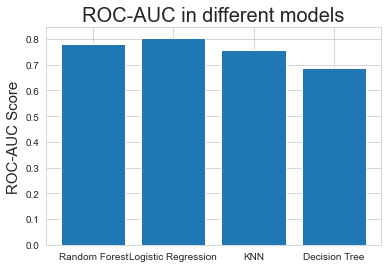

In [78]:
plt.bar(x=['Random Forest', 'Logistic Regression','KNN', 'Decision Tree'],
            height=[valid_score1, valid_score2, valid_score3, valid_score4])
plt.xlabel("", size=15)
plt.ylabel("ROC-AUC Score", size=15)
plt.title("ROC-AUC in different models", size=20)
plt.show()

In [ ]:
print('ROC-AUC score for LogisticClassifier:',valid_score_2)

Здесь мы видим, что самый большой скор у `Logistic Regression`, следующим идем `Random Forest`.

### Пробуем кросс-валидацию для RandomForest

In [79]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

In [80]:
%%time
rf_model = RandomForestClassifier(n_estimators=600, max_depth=9, max_features='auto',
                                  criterion='gini',random_state=42)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 2min 39s, sys: 1.04 s, total: 2min 40s
Wall time: 2min 40s


In [105]:
print(cv_scores_rf)

[0.77894416 0.77466402 0.77981766 0.7831249  0.78164608]


При кросс-валидации значение ROC-AUC **выше**, чем при обычном разделении на test и train

In [83]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7796393650340999


### XGBOOST

In [96]:
import xgboost

xgb = xgboost.XGBRFClassifier(n_estimators=800,  
                     learning_rate=0.1, 
                     max_depth=9, 
                     random_state=42,
                     min_child_weight=9, 
                     n_jobs=-1)


In [97]:
xgb.fit(X_train, y_train)

[15:35:30] WARNING: /private/var/folders/5l/9jtg_90x5s575m1zqn_h0kgm0000gn/T/pip-install-1g9j8bnb/xgboost_d1a94debdb7c46b09499c963911dba1a/build/temp.macosx-10.9-universal2-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                learning_rate=0.1, max_delta_step=0, max_depth=9,
                min_child_weight=9, missing=nan, monotone_constraints='()',
                n_estimators=800, n_jobs=-1, num_parallel_tree=800,
                objective='binary:logistic', predictor='auto', random_state=42,
                reg_alpha=0, scale_pos_weight=1, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [98]:
y_pred_xgb = xgb.predict_proba(X_valid)[:,1]

In [99]:
valid_score_xgb = roc_auc_score(y_valid, y_pred_xgb)

In [100]:
valid_score_xgb

0.7664447242723187

XBOOST справился почему-то хуже, чем стандартный RandomForest, а также чем LogisticClassifier

### LightGBM

In [101]:
import lightgbm

lgb = lightgbm.LGBMClassifier(n_estimators=2000, 
                     learning_rate=0.1,
                     max_depth=-1,
                     num_leaves=2**6,                     
                     random_state=42,
                     min_child_weight=7,
                     n_jobs=-1)


In [102]:
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict_proba(X_valid)[:,1]

In [103]:
roc_auc_scorec_score(y_valid, y_pred_lgb)

0.8019235647150472

LigthGBM тоже показал хорошие результаты, давайте попробуем кросс валлидацию для него

In [106]:
cv_scores_lgb = cross_val_score(lgb, X, y, cv=cv, scoring="roc_auc")

In [107]:
print(cv_scores_lgb)

[0.80192356 0.79497533 0.79920725 0.80455229 0.80471652]


In [108]:
print(f"Среднее значение ROC-AUC на кросс-валидации для LightGBM: {cv_scores_lgb.mean()}")

Среднее значение ROC-AUC на кросс-валидации для LightGBM: 0.8010749912532674


Кросс валидация получилась чуть хуже для LGB модели

### Предобработка

Прежде чем начать чтение json файла, давайте предобработаем наши данные, удалим или соединим некоторые признаки

In [113]:
for i in range(len(df_train_features.columns)):
    print(df_train_features.columns[i])

game_time
game_mode
lobby_type
objectives_len
chat_len
r1_hero_id
r1_kills
r1_deaths
r1_assists
r1_denies
r1_gold
r1_lh
r1_xp
r1_health
r1_max_health
r1_max_mana
r1_level
r1_x
r1_y
r1_stuns
r1_creeps_stacked
r1_camps_stacked
r1_rune_pickups
r1_firstblood_claimed
r1_teamfight_participation
r1_towers_killed
r1_roshans_killed
r1_obs_placed
r1_sen_placed
r2_hero_id
r2_kills
r2_deaths
r2_assists
r2_denies
r2_gold
r2_lh
r2_xp
r2_health
r2_max_health
r2_max_mana
r2_level
r2_x
r2_y
r2_stuns
r2_creeps_stacked
r2_camps_stacked
r2_rune_pickups
r2_firstblood_claimed
r2_teamfight_participation
r2_towers_killed
r2_roshans_killed
r2_obs_placed
r2_sen_placed
r3_hero_id
r3_kills
r3_deaths
r3_assists
r3_denies
r3_gold
r3_lh
r3_xp
r3_health
r3_max_health
r3_max_mana
r3_level
r3_x
r3_y
r3_stuns
r3_creeps_stacked
r3_camps_stacked
r3_rune_pickups
r3_firstblood_claimed
r3_teamfight_participation
r3_towers_killed
r3_roshans_killed
r3_obs_placed
r3_sen_placed
r4_hero_id
r4_kills
r4_deaths
r4_assists
r4_denies


Для начала применим **constant features**

In [138]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0)
sel.fit(X_train)

VarianceThreshold(threshold=0)

In [139]:
print(
    len([
        x for x in df_train_features.columns
        if x not in df_train_features.columns[sel.get_support()]
    ]))

[x for x in df_train_features.columns if x not in df_train_features.columns[sel.get_support()]]

0


[]

Этот способ не помогает выявить интересующие нас признаки, попробуем увеличить `treshhold`, тем самамым воспользуемся **quasi-constant features**

In [140]:
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train)

VarianceThreshold(threshold=0.1)

In [141]:
print(
    len([
        x for x in df_train_features.columns
        if x not in df_train_features.columns[sel.get_support()]
    ]))

[x for x in df_train_features.columns if x not in df_train_features.columns[sel.get_support()]]

30


['r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_roshans_killed',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_roshans_killed',
 'r3_firstblood_claimed',
 'r3_teamfight_participation',
 'r3_roshans_killed',
 'r4_firstblood_claimed',
 'r4_teamfight_participation',
 'r4_roshans_killed',
 'r5_firstblood_claimed',
 'r5_teamfight_participation',
 'r5_roshans_killed',
 'd1_firstblood_claimed',
 'd1_teamfight_participation',
 'd1_roshans_killed',
 'd2_firstblood_claimed',
 'd2_teamfight_participation',
 'd2_roshans_killed',
 'd3_firstblood_claimed',
 'd3_teamfight_participation',
 'd3_roshans_killed',
 'd4_firstblood_claimed',
 'd4_teamfight_participation',
 'd4_roshans_killed',
 'd5_firstblood_claimed',
 'd5_teamfight_participation',
 'd5_roshans_killed']

Здесь мы видим, что для **всех** героев одни и теже переменные неизменны, это означает, что 3 переменные (ну или 30 для всех) показывают одно значение для 99% наблюдений.

Теперь попробуем прогнать наши модели на уже очищенных данных

In [143]:
X_train_new = sel.transform(X_train)
X_valid_new = sel.transform(X_valid)

In [144]:
lg_sel = GridSearchCV(LogisticRegression(solver="liblinear", max_iter=100000),
                          {"penalty": ("l1", "l2"),
                           "C": [0.01, 0.1, 1, 10, 100]}
                          ).fit(X_train_new, y_train)

rf_model_sel = RandomForestClassifier(n_estimators=600, max_depth=9, max_features='auto',
                                      criterion='gini',random_state=42)

lgb_sel = lightgbm.LGBMClassifier(n_estimators=2000, 
                     learning_rate=0.1,
                     max_depth=-1,
                     num_leaves=2**6,                     
                     random_state=42,
                     min_child_weight=7,
                     n_jobs=-1).fit(X_train_new, y_train)

In [153]:
cv_scores_rf = cross_val_score(rf_model_sel, np.concatenate((X_train_new, X_valid_new)), 
                               y, cv=cv, scoring="roc_auc")

In [154]:
print(f"Среднее значение ROC-AUC на кросс-валидации, с чуть очищенными данными: {cv_scores_rf.mean()}") 

Среднее значение ROC-AUC на кросс-валидации, с чуть очищенными данными: 0.5014905967687834


Для RandomForest стало все намного хуже

In [157]:
y_pred_lgb_sel = lgb_sel.predict_proba(X_valid_new)[:,1]
roc_auc_score(y_valid, y_pred_lgb_sel)

0.798798528181745

In [158]:
y_pred_lg_sel = lg_sel.predict_proba(X_valid_new)[:,1]
roc_auc_score(y_valid, y_pred_lg_sel)

0.8048370180748181

Для LogisticClassifier и LightGBM ситуация праткически не изменилась. Пока придержим этот вариант

### Удалим ненужные колонки

Удалим данные о hero_id, game_mode, также я удаляю сметри, убийства, ассисты, так как потом в будущем я буду брать эту информацию из json файлов и рассчитывать KDA,колчиество убитых таверов тоде будемдобвлять с json файла

In [198]:
need_to_delete = ['game_time', 'game_mode', 'lobby_type',
                 'r1_hero_id','r1_kills','r1_deaths','r1_assists','r1_towers_killed','r1_x','r1_y',
                 'r1_obs_placed','r1_sen_placed',
                 'r2_hero_id','r2_kills','r2_deaths','r2_assists','r2_towers_killed','r2_x','r2_y',
                 'r2_obs_placed','r2_sen_placed',
                 'r3_hero_id','r3_kills','r3_deaths','r3_assists','r3_towers_killed','r3_x','r3_y',
                 'r3_obs_placed','r3_sen_placed',
                 'r4_hero_id','r4_kills','r4_deaths','r4_assists','r4_towers_killed','r4_x','r4_y',
                 'r4_obs_placed','r4_sen_placed',
                 'r5_hero_id','r5_kills','r5_deaths','r5_assists','r5_towers_killed','r5_x','r5_y',
                 'r5_obs_placed','r5_sen_placed',
                 'd1_hero_id','d1_kills','d1_deaths','d1_assists','d1_towers_killed','d1_x','d1_y',
                 'd1_obs_placed','d1_sen_placed',
                 'd2_hero_id','d2_kills','d2_deaths','d2_assists','d2_towers_killed','d2_x','d2_y',
                 'd2_obs_placed','d2_sen_placed',
                 'd3_hero_id','d3_kills','d3_deaths','d3_assists','d3_towers_killed','d3_x','d3_y',
                 'd3_obs_placed','d3_sen_placed',
                 'd4_hero_id','d4_kills','d4_deaths','d4_assists','d4_towers_killed','d4_x','d4_y',
                 'd4_obs_placed','d4_sen_placed',
                 'd5_hero_id','d5_kills','d5_deaths','d5_assists','d5_towers_killed','d5_x','d5_y',
                 'd5_obs_placed','d5_sen_placed',]

In [199]:
df_train_features_dropd = df_train_features.drop(need_to_delete, axis = 1)

In [200]:
df_train_features_dropd.head()

,objectives_len,chat_len,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,...,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_roshans_killed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,3,10,7,5257,52,3937,1160,1160,566.93805,8,...,800,446.93793,4,0.000000,0,0,0,0,0.00,0
6db558535151ea18ca70a6892197db41,0,0,0,176,0,0,680,680,506.93800,1,...,640,446.93793,1,0.000000,0,0,0,0,0.00,0
19c39fe2af2b547e48708ca005c6ae74,0,0,1,403,0,359,740,740,290.93777,2,...,680,278.93777,2,0.000000,0,0,0,0,0.00,0
c96d629dc0c39f0c616d1949938a6ba6,1,0,5,3085,1,2828,495,740,816.93830,6,...,800,626.93810,8,8.264696,0,0,3,0,0.25,0
156c88bff4e9c4668b0f53df3d870f1b,2,2,9,3516,40,3964,495,960,530.93800,8,...,620,434.93793,3,15.762911,3,1,0,1,0.50,0


### Чтение JSON файлов

In [194]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(800):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

Посмотрим на все параметры, которые у нас есть в json файле

In [174]:
match.keys()  

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

Посмотрим, какая информация находится для одного игрока

In [184]:
match['players'][1]

{'player_slot': 1,
 'hero_id': 86,
 'hero_name': 'npc_dota_hero_rubick',
 'account_id_hash': '1c2500195e6ab646fc9371344724aa77',
 'ability_upgrades': [{'ability': 5448, 'time': 294, 'level': 1},
  {'ability': 5450, 'time': 444, 'level': 2},
  {'ability': 5450, 'time': 509, 'level': 3},
  {'ability': 5451, 'time': 670, 'level': 4},
  {'ability': 5450, 'time': 801, 'level': 5},
  {'ability': 5452, 'time': 894, 'level': 6},
  {'ability': 5450, 'time': 981, 'level': 7},
  {'ability': 5448, 'time': 1120, 'level': 8},
  {'ability': 5448, 'time': 1335, 'level': 9},
  {'ability': 6366, 'time': 1433, 'level': 10},
  {'ability': 5448, 'time': 1653, 'level': 11}],
 'obs_placed': 0,
 'sen_placed': 2,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 1,
 'firstblood_claimed': 0,
 'teamfight_participation': 0.667,
 'towers_killed': 0,
 'roshans_killed': 0,
 'observers_placed': 0,
 'stuns': 19.828,
 'max_hero_hit': {'type': 'max_hero_hit',
  'time': 764.313,
  'max': True,
  'inflictor': 'i

Посмотрев на несколько объектов в json файле, я обнаружил, что по-видимому самым информативным признаком является `players` его и нужно посмотреть более детально. Я предполагаю, что если добавить информацию о количестве суммарное KDA для каждой команды, а также количестве подобранных рун, то мы можем улучшить наш скор, давайте попробуем все это! Стоит добавить также количество разрущенных башен, в бейслайне этот признак хорошо показал себя.

### Создадим функцию, которая читает json файл

In [185]:
import ujson as json
from tqdm.notebook import tqdm
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Теперь попробуем добавить фичи, о которых я говорил ранее

In [186]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем поднятые, кол-во убитых башен, а также KDA для каждой команды 
        rune_r = 0
        rune_d = 0
        KDA_r = 0
        KDA_d = 0
        towers_r = 0 
        towers_d = 0
        for player in match["players"]:
            if player["player_slot"] in list(range(0,5)):
                rune_r += player['rune_pickups']
                towers_r += player['towers_killed']
                try:
                    KDA_r += (player['kills'] + player['assists']) / player['deaths'] 
                except ZeroDivisionError:
                    KDA_r += player['kills'] + player['assists']
            elif player["player_slot"] in list(range(128,133)):
                rune_d += player['rune_pickups']
                towers_d += player['towers_killed']
                try:
                    KDA_d += (player['kills'] + player['assists']) / player['deaths'] 
                except ZeroDivisionError:
                    KDA_d += player['kills'] + player['assists']   

        df_features.loc[match_id_hash, "diff_rune_taken"] = rune_r - rune_d      
        df_features.loc[match_id_hash, "diff_in_KDA"] = KDA_r - KDA_d
        df_features.loc[match_id_hash, "diff_in_towers"] = towers_r - towers_d
        

In [201]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features_dropd.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [202]:
df_train_features_extended.head()

,objectives_len,chat_len,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_roshans_killed,diff_rune_taken,diff_in_KDA,diff_in_towers
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,3,10,7,5257,52,3937,1160,1160,566.93805,8,...,0.000000,0,0,0,0,0.00,0,-1.0,24.5,1.0
6db558535151ea18ca70a6892197db41,0,0,0,176,0,0,680,680,506.93800,1,...,0.000000,0,0,0,0,0.00,0,2.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,0,0,1,403,0,359,740,740,290.93777,2,...,0.000000,0,0,0,0,0.00,0,7.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1,0,5,3085,1,2828,495,740,816.93830,6,...,8.264696,0,0,3,0,0.25,0,20.0,-2.9,0.0
156c88bff4e9c4668b0f53df3d870f1b,2,2,9,3516,40,3964,495,960,530.93800,8,...,15.762911,3,1,0,1,0.50,0,-3.0,-6.0,-1.0


In [203]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 27 ms, sys: 87.3 ms, total: 114 ms
Wall time: 1min 6s


In [204]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7796393650340999
ROC-AUC на кросс-валидации для новых признаков: 0.7873243668190365


### Пробуем другие модели

In [221]:
X = df_train_features_extended.values
X_train_final, X_valid_final, y_train_final, y_valid_final = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=42)

In [237]:
lg_final = LogisticRegression(solver="liblinear", max_iter=100000, C=0.1, 
                            penalty = 'l1').fit(X_train_final, y_train_final)
y_pred_lg_final = lg_final.predict_proba(X_valid_final)[:,1]
print(roc_auc_score(y_valid_final, y_pred_lg_final))


0.8075426522982592


## Лучший скор сверху!!

In [223]:
lgb_final = lightgbm.LGBMClassifier(n_estimators=2000, 
                     learning_rate=0.1,
                     max_depth=-1,
                     num_leaves=2**6,                     
                     random_state=42,
                     min_child_weight=7,
                     n_jobs=-1).fit(X_train_final, y_train_final)

y_pred_lgb_final = lgb_final.predict_proba(X_valid_final)[:,1]
print(roc_auc_score(y_valid_final, y_pred_lgb_final))

0.7907058039150948


In [224]:
%%time
cv_scores_base = cross_val_score(lgb_final, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 35.5 ms, sys: 97.5 ms, total: 133 ms
Wall time: 54.7 s


In [225]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7936239515965815
ROC-AUC на кросс-валидации для новых признаков: 0.7873243668190365


Кросс-валидация для LigthGBM не работает

### Теперь опять попробуем LogisticRegression и LigthGBM, дропаем данные с помощью quasi-constant features

In [227]:
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_final)

VarianceThreshold(threshold=0.1)

In [231]:
X_train_new_final = sel.transform(X_train_final)
X_valid_new_final = sel.transform(X_valid_final)

In [235]:
lgb_new_final = lightgbm.LGBMClassifier(n_estimators=2000, 
                     learning_rate=0.1,
                     max_depth=-1,
                     num_leaves=2**6,                     
                     random_state=42,
                     min_child_weight=7,
                     n_jobs=-1).fit(X_train_new_final, y_train_final)

y_pred_lgb_new_final = lgb_final.predict_proba(X_valid_new_final)[:,1]
print(roc_auc_score(y_valid_final, y_pred_lgb_new_final))

0.7915883599319391


In [236]:
lg_new_final = LogisticRegression(solver="liblinear", max_iter=100000, C=0.1, 
                            penalty = 'l1').fit(X_train_new_final, y_train_final)
y_pred_lg_new_final = lg_new_final.predict_proba(X_valid_new_final)[:,1]
print(roc_auc_score(y_valid_final, y_pred_lg_new_final))

0.8072863877890029


Если дропаем данные с помощью quasi-constant features, наши две модели становятся хуже

### Submit

In [243]:
def read_matches_test(matches_file, total_matches=7977, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

In [244]:
def add_new_features_test(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches_test(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем поднятые, кол-во убитых башен, а также KDA для каждой команды 
        rune_r = 0
        rune_d = 0
        KDA_r = 0
        KDA_d = 0
        towers_r = 0 
        towers_d = 0
        for player in match["players"]:
            if player["player_slot"] in list(range(0,5)):
                rune_r += player['rune_pickups']
                towers_r += player['towers_killed']
                try:
                    KDA_r += (player['kills'] + player['assists']) / player['deaths'] 
                except ZeroDivisionError:
                    KDA_r += player['kills'] + player['assists']
            elif player["player_slot"] in list(range(128,133)):
                rune_d += player['rune_pickups']
                towers_d += player['towers_killed']
                try:
                    KDA_d += (player['kills'] + player['assists']) / player['deaths'] 
                except ZeroDivisionError:
                    KDA_d += player['kills'] + player['assists']   

        df_features.loc[match_id_hash, "diff_rune_taken"] = rune_r - rune_d      
        df_features.loc[match_id_hash, "diff_in_KDA"] = KDA_r - KDA_d
        df_features.loc[match_id_hash, "diff_in_towers"] = towers_r - towers_d
        

In [260]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")


df_test_features_extended = df_test_features.drop(need_to_delete, axis=1)

add_new_features_test(df_test_features_extended,
                              "data/test_raw_data.jsonl")

X_test = df_test_features_extended.values
X_test_new = sel.transform(X_test)
y_test_pred = lg_new_final.predict_proba(X_test_new)[:, 1]



df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [261]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_22-19-51.csv


В результате преобразований были протестированы и откинуты следующие признаки: 
* Количество убитых рошанов
* Время, в котором команда держала в стане команду
* Количество времени, потраченного на файты
* Количество поставленных вардов

Все эти признаки не дали должного результата, по итогу добавилось только KDA, количество разрущенных башен, количество подобранных рун